In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import fft
import wave
import sys
import os
from scipy.io.wavfile import write
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.io import wavfile
import scipy.signal as signal
import librosa

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np
import scipy.signal
from torch.cuda.amp import autocast, GradScaler
from torch.utils.checkpoint import checkpoint

path = 'C:/Users/User/Desktop/AppStat/MachineLearning/AppliedML2024/final_project/data/nsynth-valid/audio/'

In [2]:
def read_files_in_dir(directory):
    filenames = os.listdir(directory)
    return filenames


def audio_to_waveform(audio):
    waveform, sr = librosa.load(audio, sr=None)
    return waveform, sr

def waveform_to_spectogram(waveform):
    if waveform.dtype != np.float32:
        waveform = waveform.astype(np.float32)
    spectrogram = librosa.stft(waveform)
    return np.abs(spectrogram)

def pad_spectrogram(spec, target_shape):
    padded_spec = np.zeros(target_shape,dtype = np.float32)
    min_shape = np.minimum(target_shape, spec.shape)
    padded_spec[:min_shape[0], :min_shape[1]] = spec[:min_shape[0], :min_shape[1]]
    return padded_spec

def spectogram_to_audio(spectrogram, sr,output_wav):
    waveform = librosa.istft(spectrogram)
    waveform = np.nan_to_num(waveform)
    waveform = waveform/np.max(np.abs(waveform))
    return write(output_wav, sr, (waveform*32767).astype(np.int16))

def normalize_spectrogram(spectrogram):
    min_val = np.min(spectrogram)
    max_val = np.max(spectrogram)
    normalized_spectrogram = (spectrogram - min_val) / (max_val - min_val + 1e-6)
    return normalized_spectrogram



def pick_samples_and_classify(arrays):
    # Picks a random number of samples and returns their filepath and label
    instruments = []
    # Pick at minimum two instruments
    number_of_instruments = np.random.randint(2, len(arrays) + 1)
    labels = np.zeros(len(arrays))
    already_picked = []

    while len(instruments) < number_of_instruments:
        random_pick = np.random.randint(0, len(arrays))
        if random_pick in already_picked:
            continue  # Skip this iteration and proceed to the next iteration
        else:
            already_picked.append(random_pick)
            pick = np.random.choice(arrays[random_pick], 1)
            instruments.append(pick)
            labels[random_pick] = 1

    # Continue adding instruments until the length of instruments is 3 or greater
    while len(instruments) < 2:
        random_pick = np.random.randint(0, len(arrays))
        if random_pick in already_picked:
            continue  # Skip this iteration and proceed to the next iteration
        else:
            already_picked.append(random_pick)
            pick = np.random.choice(arrays[random_pick], 1)
            instruments.append(pick)
            labels[random_pick] = 1

    return instruments, labels


#read the filenames, and add their data to 5 lists
def add_waveform_to_list(filenames):
    waveforms = []
    for filename in filenames:
        waveform, params = audio_to_waveform(path + filename[0])
        waveforms.append(waveform)
    return waveforms

def find_longest_array(arrays):
    longest = 0
    for array in arrays:
        if len(array) > longest:
            longest = len(array)
    return longest

def combine_waveforms(waveforms):
    normalization = 1 / len(waveforms)
    # changed to be equal to the length of the longest waveform
    out = np.zeros(find_longest_array(waveforms), dtype=np.float32)
    for w in waveforms:
        out += w.astype(np.float32) * normalization
    return out

# Function to plot spectrogram using librosa
def plot_spectrogram(waveform, sr, title):
    # Compute the STFT
    D = librosa.stft(waveform)
    # Convert to magnitude
    D_mag = np.abs(D)
    print(D_mag.shape)
    # Plot the spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(librosa.amplitude_to_db(D_mag, ref=np.max), sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

def plot_separated_spectrograms(output_tensor, sr):
    for i, spec in enumerate(output_tensor):
        plt.figure(figsize=(15, 5))
        librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.title(f'Separated Spectrogram {i + 1}')
        plt.show()

def torch_normalize(spectogram):
    min_val = torch.min(spectogram)
    max_val = torch.max(spectogram)
    normalized_spectogram = (spectogram - min_val) / (max_val - min_val)
    return normalized_spectogram

def to_mel_spectrogram(spectrogram,sr, n_mels=128):
    return librosa.feature.melspectrogram(y = None, sr=sr, S = spectrogram, n_mels=128)


In [3]:
filenames = read_files_in_dir(path)
#pianos = [filename for filename in filenames if "piano" in filename] #empty
bass = [filename for filename in filenames if "bass" in filename]
guitar = [filename for filename in filenames if "guitar" in filename]
#drum = [filename for filename in filenames if "drum" in filename] #empty
flutes = [filename for filename in filenames if "flute" in filename]
keyboards = [filename for filename in filenames if "keyboard" in filename] 
guitar_acoustic = [filename for filename in filenames if "guitar_acoustic" in filename]
flute_acoustic = [filename for filename in filenames if "flute_acoustic" in filename]
bass_electronic = [filename for filename in filenames if "bass_electronic" in filename]
vocals = [filename for filename in filenames if "vocal" in filename]
organ = [filename for filename in filenames if "organ" in filename]

In [4]:
def nu_gen_spectro_mel(N, target_shape=(129, 285),sr = 22050, nperseg=2048, noverlap=512):
    data = []
    labels = []
    original_labels = []
    #instrument_list = [bass, guitar, flutes, keyboards]
    instrument_list = [organ, vocals, flutes]

    for i in range(N):
        
        paths, label = pick_samples_and_classify(instrument_list)
        original_labels.append(label)
        waveforms = add_waveform_to_list(paths)
        mixed_waveform = combine_waveforms(waveforms)
        
        #audio = audio_to_waveform(mixed_waveform)
        mixed_spectro = waveform_to_spectogram(mixed_waveform)
        #mixed_spectro = audio_to_spectrogram(mixed_waveform)
        mixed_spectro_padded = pad_spectrogram(mixed_spectro, target_shape)
        mixed_spectro_normalized = normalize_spectrogram(mixed_spectro_padded)
        
        inter_waveforms = []
        inst_i = 0
        for n, i in enumerate(label):
            if i == 1:
                spectro = waveform_to_spectogram(waveforms[inst_i])
                spectro_padded = pad_spectrogram(spectro, target_shape)
                inter_waveforms.append(to_mel_spectrogram(spectro_padded,sr))
                inst_i += 1

            if i == 0:
                inter_waveforms.append(to_mel_spectrogram(np.zeros(target_shape,sr)))

        data.append(to_mel_spectrogram(mixed_spectro_normalized,sr))
        #inter_waveforms.append(np.zeros(target_shape))
        labels.append(inter_waveforms)
    
    data = np.array(data)
    
    return data, np.array(labels), np.array(original_labels)

In [5]:
def nu_gen_spectro(N, target_shape=(1025, 126)):
    data = []
    labels = []
    original_labels = []
    #instrument_list = [bass, guitar, flutes]
    #instrument_list = [organ, vocals, flutes]
    instrument_list = [organ, flutes]

    for i in range(N):
        paths, label = pick_samples_and_classify(instrument_list)
        original_labels.append(label)
        waveforms = add_waveform_to_list(paths)
        mixed_waveform = combine_waveforms(waveforms)
        
        #audio = audio_to_waveform(mixed_waveform)
        mixed_spectro = waveform_to_spectogram(mixed_waveform)
        #mixed_spectro = audio_to_spectrogram(mixed_waveform)
        mixed_spectro_padded = pad_spectrogram(mixed_spectro, target_shape)
        mixed_spectro_normalized = normalize_spectrogram(mixed_spectro_padded)
        
        inter_waveforms = []
        

        inst_i = 0
        for n, i in enumerate(label):
            if i == 1:
                spectro = waveform_to_spectogram(waveforms[inst_i])
                spectro_padded = pad_spectrogram(spectro, target_shape)
                inter_waveforms.append(spectro_padded)
                
                inst_i += 1

            if i == 0:
                inter_waveforms.append(np.zeros(target_shape))

        data.append(mixed_spectro_normalized)
        #inter_waveforms.append(np.zeros(target_shape))
        labels.append(inter_waveforms)
    
    data = np.array(data)
    
    return data, np.array(labels), np.array(original_labels)# remove last line if you want to return only data and labels

In [6]:
# Depthwise Separable Convolution
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, dilation = 1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, padding=padding,dilation = dilation, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

# Bottleneck Block
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=1):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = DepthwiseSeparableConv(out_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        out += identity
        return self.relu(out)
    

In [7]:
class AudioDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [8]:
class UNet(nn.Module):
    def __init__(self, input_channels=1, output_channels=2):
        super(UNet, self).__init__()

        # Contracting path with Bottleneck Blocks
        self.conv1 = nn.Conv2d(input_channels, 8, (3, 3), padding=(1, 1))
        self.conv2 = BottleneckBlock(8, 16)
        self.dropout = nn.Dropout(0.2)
        self.conv3 = BottleneckBlock(16, 32, dilation=2)
        self.conv4 = BottleneckBlock(32, 64, dilation=4)
        self.conv5 = BottleneckBlock(64, 128, dilation=8)
        self.conv6 = BottleneckBlock(128, 256, dilation=16)
        self.conv7 = BottleneckBlock(256, 512, dilation=32)
        self.pool = nn.MaxPool2d(2, 2)

        # Add temporal convolutions (1D) for time dependencies
        #self.temporal_conv1 = nn.Conv1d(512, 256, kernel_size=3, padding=1)
        #self.temporal_bn1 = nn.BatchNorm1d(256)
        #self.temporal_conv2 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        #self.temporal_bn2 = nn.BatchNorm1d(128)
        #self.temporal_conv3 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        #self.temporal_bn3 = nn.BatchNorm1d(64)
        
       # self.temporal_conv4 = nn.Conv1d(64, 512, kernel_size=3, padding=1)
      
        #self.temporal_bn4 = nn.BatchNorm1d(512)
       # print("temporal_conv4 weights:", self.temporal_conv4.weight)
       # print("temporal_conv4 biases:", self.temporal_conv4.bias)
        # Upsampling path
        self.upconv1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv8 = BottleneckBlock(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv9 = BottleneckBlock(256, 128)
        #print("upconv2 weights:", self.upconv2.weight)
        #print("upconv2 biases:", self.upconv2.bias)
        self.upconv3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv10 = BottleneckBlock(128, 64)
        self.upconv4 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv11 = BottleneckBlock(64, 32)
        self.upconv5 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.conv12 = BottleneckBlock(32, 16)
        self.upconv6 = nn.ConvTranspose2d(16, 8, 2, stride=2)
        self.conv13 = BottleneckBlock(16, 8)
        self.final_conv = nn.Conv2d(8, output_channels, 3, padding=1)

    def forward(self, x):
      #  print("Input shape:", x.shape)
        #print("Input contains NaNs:", torch.isnan(x).any(), "Infs:", torch.isinf(x).any())
        
        x = self.dropout(x)
        x1 = checkpoint(self.conv1, x)
       # print("After conv1:", x1.shape, "NaNs:", torch.isnan(x1).any(), "Infs:", torch.isinf(x1).any())
        
        x2 = checkpoint(self.conv2, self.pool(x1), use_reentrant=True)
       # print("After conv2:", x2.shape, "NaNs:", torch.isnan(x2).any(), "Infs:", torch.isinf(x2).any())
        
        x3 = checkpoint(self.conv3, self.pool(x2), use_reentrant=True)
        #print("After conv3:", x3.shape, "NaNs:", torch.isnan(x3).any(), "Infs:", torch.isinf(x3).any())
        
        x4 = checkpoint(self.conv4, self.pool(x3), use_reentrant=True)
        #print("After conv4:", x4.shape, "NaNs:", torch.isnan(x4).any(), "Infs:", torch.isinf(x4).any())
        
        x5 = checkpoint(self.conv5, self.pool(x4), use_reentrant=True)
       # print("After conv5:", x5.shape, "NaNs:", torch.isnan(x5).any(), "Infs:", torch.isinf(x5).any())
        
        x6 = checkpoint(self.conv6, self.pool(x5), use_reentrant=True)
       # print("After conv6:", x6.shape, "NaNs:", torch.isnan(x6).any(), "Infs:", torch.isinf(x6).any())
        
        x7 = checkpoint(self.conv7, self.pool(x6), use_reentrant=True)
       # print("After conv7:", x7.shape, "NaNs:", torch.isnan(x7).any(), "Infs:", torch.isinf(x7).any())
        
        # Reshape for temporal convolutions (collapse frequency dimension)
      #  x = x7.view(x7.size(0), x7.size(1), -1)
      #  x = F.relu(self.temporal_bn1(self.temporal_conv1(x)))
        #print("After temporal_conv1:", x.shape, "NaNs:", torch.isnan(x).any(), "Infs:", torch.isinf(x).any())
        
       # x = F.relu(self.temporal_bn2(self.temporal_conv2(x)))
        #print("After temporal_conv2:", x.shape, "NaNs:", torch.isnan(x).any(), "Infs:", torch.isinf(x).any())
        
       # x = F.relu(self.temporal_bn3(self.temporal_conv3(x)))
        #print("After temporal_conv3:", x.shape, "NaNs:", torch.isnan(x).any(), "Infs:", torch.isinf(x).any())
        #print(x.shape)
       # x = F.relu(self.temporal_bn4(self.temporal_conv4(x)))
        #print("After temporal_conv4:", x.shape, "NaNs:", torch.isnan(x).any(), "Infs:", torch.isinf(x).any())
        #print(x.shape)
       # x = x.view(x.size(0), x.size(1), 1, -1)
        
        x = self.upconv1(x7)
        x = F.interpolate(x, size=(x6.size(2), x6.size(3)), mode='nearest')
        x = torch.cat([x, x6], dim=1)
        x = checkpoint(self.conv8, x)
       # print("After upconv1 and conv8:", x.shape, "NaNs:", torch.isnan(x).any(), "Infs:", torch.isinf(x).any())
        
        x = self.upconv2(x)
        x = F.interpolate(x, size=(x5.size(2), x5.size(3)), mode='nearest')
        # Print shapes for debugging
        #print("Shape of x after upconv2:", x.shape)
        #print("Shape of x5:", x5.shape)
        # Check for NaNs and Infs
        #if torch.isnan(x).any() or torch.isinf(x).any():
         #   print("NaN or Inf values in x after upconv2!")
        #if torch.isnan(x5).any() or torch.isinf(x5).any():
        #    print("NaN or Inf values in x5!")
        x = torch.cat([x, x5], dim=1)
        # Check shape after concatenation
        #print("Shape after concatenation:", x.shape)

        # Check for NaNs and Infs after concatenation
        #if torch.isnan(x).any() or torch.isinf(x).any():
         #   print("NaN or Inf values after concatenation!")
        x = checkpoint(self.conv9, x,use_reentrant=False)
        #print("After upconv2 and conv9:", x.shape, "NaNs:", torch.isnan(x).any(), "Infs:", torch.isinf(x).any())
        
        x = self.upconv3(x)
        x = F.interpolate(x, size=(x4.size(2), x4.size(3)), mode='nearest')
        x = torch.cat([x, x4], dim=1)
        x = checkpoint(self.conv10, x,use_reentrant=False)
        #print("After upconv3 and conv10:", x.shape, "NaNs:", torch.isnan(x).any(), "Infs:", torch.isinf(x).any())
        
        x = self.upconv4(x)
        x = F.interpolate(x, size=(x3.size(2), x3.size(3)), mode='nearest')
        x = torch.cat([x, x3], dim=1)
        x = checkpoint(self.conv11, x,use_reentrant=False)
       # print("After upconv4 and conv11:", x.shape, "NaNs:", torch.isnan(x).any(), "Infs:", torch.isinf(x).any())
        
        x = self.upconv5(x)
        x = F.interpolate(x, size=(x2.size(2), x2.size(3)), mode='nearest')
        x = torch.cat([x, x2], dim=1)
        x = checkpoint(self.conv12, x,use_reentrant=False)
        #print("After upconv5 and conv12:", x.shape, "NaNs:", torch.isnan(x).any(), "Infs:", torch.isinf(x).any())
        
        x = self.upconv6(x)
        x = F.interpolate(x, size=(x1.size(2), x1.size(3)), mode='nearest')
        x = torch.cat([x, x1], dim=1)
        x = checkpoint(self.conv13, x, use_reentrant=False)
        #print("After upconv6 and conv13:", x.shape, "NaNs:", torch.isnan(x).any(), "Infs:", torch.isinf(x).any())
        
        x = self.final_conv(x)
       # print("Final output:", x.shape, "NaNs:", torch.isnan(x).any(), "Infs:", torch.isinf(x).any())
        return x


In [9]:
def torch_normalize(spectogram):
    min_val = torch.min(spectogram)
    max_val = torch.max(spectogram)
    normalized_spectogram = (spectogram - min_val) / (max_val - min_val)
    return normalized_spectogram

### Loss Functions

In [10]:
from mir_eval.separation import bss_eval_sources
import torch
import torch.nn as nn
import numpy as np

class MirEvalLoss(nn.Module):
    def __init__(self, metric='sdr'):
        super(MirEvalLoss, self).__init__()
        self.metric = metric

    def forward(self, y_pred, y_true):
        """
        Args:
            y_pred (torch.Tensor): Predicted source signals of shape (batch_size, num_sources, height, width)
            y_true (torch.Tensor): True source signals of shape (batch_size, num_sources, height, width)
        """
        batch_size = y_pred.shape[0]
        num_sources = y_pred.shape[1]
       # print(num_sources)
        total_loss = 0.0
        
        for i in range(num_sources):
            pred_np = y_pred[:, i].detach().cpu().numpy()
            true_np = y_true[:, i].detach().cpu().numpy()

            # Flatten the predictions and true sources for evaluation
            pred_flat = pred_np.reshape(batch_size, -1)
            true_flat = true_np.reshape(batch_size, -1)
            # Check if the true sources are all zeros for this channel
            if np.sum(true_np== 0):
                #print(f"Skipping evaluation for channel {i} since all true sources are zeros.")
                continue
            # Calculate the evaluation metric
            sdr, _, _, _ = bss_eval_sources(true_flat, pred_flat)

            # Calculate the mean loss based on the specified metric
            if self.metric == 'sdr':
                loss = -torch.tensor(sdr).mean()  # Negative SDR for minimization
            else:
                raise ValueError(f"Unsupported metric: {self.metric}")

            total_loss += loss

        # Calculate the average loss across all sources
        avg_loss = total_loss / num_sources

        return avg_loss


In [11]:
class AbsDiffLoss(nn.Module):
    def __init__(self):
        super(AbsDiffLoss, self).__init__()

    def forward(self, y_pred, y_true,X):
        #print(y_pred[:,0,:])
        #print(y_true[:,0,:])
        epsilon = 1e-6
        log_diffs = 0
        for i in range(len(y_pred[1])):
            log_diffs += torch.sum(torch.abs(y_pred[:,i,:] + epsilon - y_true[:,i,:] + epsilon))
        

        #l1_loss2 = F.mse_loss(y_pred[:,2,:], y_true[:,2,:])
  
        sq_X = torch.squeeze(X)
        summed_spectogram = torch.sum(y_pred, dim=1)
        diff = torch.abs(torch_normalize(summed_spectogram) - torch_normalize(sq_X))
        regulator = 10000
        penalty = torch.sum(diff)
        #print(penalty)
        l1_loss = log_diffs + regulator*penalty
        return l1_loss

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SSIMLoss(nn.Module):
    def __init__(self):
        super(SSIMLoss, self).__init__()

    def forward(self, y_pred, y_true, X):
        """
        Args:
            y_pred (torch.Tensor): Predicted source signals of shape (batch_size, num_sources, height, width)
            y_true (torch.Tensor): True source signals of shape (batch_size, num_sources, height, width)
        """
        # Calculate SSIM loss for each channel independently
        ssim_loss = 1.0 - torch.mean(torch.stack([self.ssim_loss_single_channel(y_pred[:, i], y_true[:, i]) for i in range(y_pred.shape[1])]))

        return ssim_loss

    def ssim_loss_single_channel(self, img1, img2, window_size=11, sigma=1.5):
        mu1 = F.avg_pool2d(img1, window_size, stride=1, padding=window_size // 2)
        mu2 = F.avg_pool2d(img2, window_size, stride=1, padding=window_size // 2)

        mu1_sq = mu1 ** 2
        mu2_sq = mu2 ** 2
        mu1_mu2 = mu1 * mu2

        sigma1_sq = F.avg_pool2d(img1 ** 2, window_size, stride=1, padding=window_size // 2) - mu1_sq
        sigma2_sq = F.avg_pool2d(img2 ** 2, window_size, stride=1, padding=window_size // 2) - mu2_sq
        sigma12 = F.avg_pool2d(img1 * img2, window_size, stride=1, padding=window_size // 2) - mu1_mu2

        C1 = (0.01 * 255) ** 2
        C2 = (0.03 * 255) ** 2

        ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

        return torch.clamp((1 - ssim_map) / 2, 0, 1)  # Clamp values to [0, 1] range and return 1 - SSIM


In [13]:
import torch

def pit_loss(estimated_sources, true_sources):
    """
    Compute the permutation invariant training (PIT) loss.
    
    Arguments:
    estimated_sources -- Tensor of shape (batch_size, num_sources, num_samples)
                         containing the estimated sources.
    true_sources -- Tensor of shape (batch_size, num_sources, num_samples)
                    containing the ground truth sources.
    
    Returns:
    loss -- PIT loss value.
    """
    # Compute pairwise L2 distances between estimated and true sources
    pairwise_distances = torch.norm(estimated_sources.unsqueeze(1) - true_sources.unsqueeze(2), dim=-1)
    
    # Find the best permutation that minimizes the total distance
    min_distances, _ = torch.min(pairwise_distances, dim=-1)
    
    # Compute the average loss over the batch
    loss = torch.mean(min_distances)
    
    return loss


In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class SDRLoss(nn.Module):
    def __init__(self, smoothness_lambda=0.1, deviation_lambda=10,diversity_lambda = 0.1):
        super(SDRLoss, self).__init__()
        self.smoothness_lambda = smoothness_lambda
        self.deviation_lambda = deviation_lambda
        self. diversity_lambda = diversity_lambda
        
    def forward(self, y_pred, y_true, X, model_parameters=None):

        #y_true = torch_normalize(y_true)
        #y_pred = torch_normalize(y_pred)
        delta = 1e-7  # avoid numerical errors
        num = torch.sum(torch.square(torch.squeeze(y_true)), dim=(2, 3))
        den = torch.sum(torch.square(torch.squeeze(y_true - y_pred)), dim=(2, 3))
        num += delta
        den += delta
        scores = 10 * torch.log10(num / den)

        # Negative SDR score penalty which is equal to the amount of negative SDR
        #negative_penalty =torch.sum(torch.clamp(scores, max=0))

        negative_scores = torch.clamp(scores, max=0)
        penalty_negative = torch.sum(-negative_scores)
    
        
        # Negative SDR score penalty
        # Calculate penalty based on the minimum negative SDR score

        #negative_scores = torch.clamp(scores, max=0)
        #penalty_negative = torch.sum(-negative_scores)
        # TV regularization penalty
        # Calculate the total variation of the estimated sources
        #TV_penalty = 0
        #for i in range(len(y_pred[1])):
        #    TV_penalty += torch.sum(torch.abs(y_pred[:,i, :, 1:] - y_pred[:,i, :, :-1])) + torch.sum(torch.abs(y_pred[:,i, 1:, :] - y_pred[:,i, :-1, :]))
        pit_loss_value = pit_loss(y_pred, y_true)
        # Coherence penalty between the estimated and true sources 
        #sq_X = torch.squeeze(X)
        #summed_spectogram = torch.sum(y_pred, dim=1)
        #diff = torch.mean(torch.abs(summed_spectogram - sq_X))
        
        # Diversity Penalty: Penalize similarity between different y_pred spectrograms
        diversity_penalty = 0
        num_sources = y_pred.size(1)
        for i in range(num_sources):
            for j in range(i + 1, num_sources):
                similarity = torch.norm(y_pred[:, i, :, :] - y_pred[:, j, :, :], p=2).mean()
                diversity_penalty += 1 / (similarity + 1e-7)  # Adding a small constant to avoid division by zero
        diversity_penalty *= self.diversity_lambda
        


        total_penalty = (
             self.smoothness_lambda * pit_loss_value + penalty_negative * 0.1
             + diversity_penalty * 10 
        )
        print(f"Loss : {-torch.mean(scores) + total_penalty}, SDR : {torch.mean(scores)}, Penalty : {total_penalty}", end = '\r')
        return -torch.mean(scores) + total_penalty

# Example usage:
# sdr_loss = SDRLoss(l2_lambda=0.01, smoothness_lambda=0.01, deviation_lambda=0.01)
# loss = sdr_loss(references, estimates, model.parameters())


In [15]:
class MSELoss(nn.Module):
    def __init__(self):
        super(MSELoss, self).__init__()

    def forward(self, y_pred, y_true,X):
        l1_loss = 0
        #print(y_pred)
        for i in range(len(y_pred[1])):
            l1_loss += F.mse_loss(y_pred[:,i,:], y_true[:,i,:])
        #l1_loss0 = F.mse_loss(y_pred[:,0,:], y_true[:,0,:])
        #l1_loss1 = F.mse_loss(y_pred[:,1,:], y_true[:,1,:])
        #l1_loss2 = F.mse_loss(y_pred[:,2,:], y_true[:,2,:])
        #y_pred = torch.clamp(y_pred, min=0)
        sq_X = torch.squeeze(X)
        summed_spectogram = torch.sum(y_pred, dim=1)
        diff = torch.abs(torch_normalize(summed_spectogram) - torch_normalize(sq_X))
        regulator = 1000
        penalty = torch.mean(diff)
        #print(penalty)
        l1_loss = torch.mean(l1_loss) + regulator*penalty
        return l1_loss

In [16]:


def power_iteration(matrix, num_iters=10, batch_size=1):
    """
    Computes the largest singular value of `matrix` using power iteration.
    
    Args:
        matrix (torch.Tensor): The matrix for which to compute the largest singular value.
        num_iters (int): Number of iterations for the power iteration method.
        batch_size (int): Batch size for the power method.

    Returns:
        torch.Tensor: The largest singular value.
    """
    vec = torch.randn((matrix.shape[1], batch_size), device=matrix.device, dtype=torch.float32)
    
    for _ in range(num_iters):
        vec = torch.matmul(matrix, vec)
        vec = vec / vec.norm()
    
    singular_value = (vec.T @ matrix @ vec).sum().sqrt()
    
    return singular_value

def svd_penalty(model, min_size=0.1, dim=1, niters=3, powm=False, convtr=True,
                proba=0.3, conv_only=False, exact=False, bs=32):
    
    """
    Penalty on the largest singular value for a layer.
    Args:
        - model: model to penalize
        - min_size: minimum size in MB of a layer to penalize.
        - dim: projection dimension for the svd_lowrank. Higher is better but slower.
        - niters: number of iterations in the algorithm used by svd_lowrank.
        - powm: use power method instead of lowrank SVD, my own experience
            is that it is both slower and less stable.
        - convtr: when True, differentiate between Conv and Transposed Conv.
            this is kept for compatibility with older experiments.
        - proba: probability to apply the penalty.
        - conv_only: only apply to conv and conv transposed, not LSTM
            (might not be reliable for other models than Demucs).
        - exact: use exact SVD (slow but useful at validation).
        - bs: batch_size for power method.
    """

    total = 0
    torch.set_default_dtype(torch.float32)
    if torch.rand(1).item() > proba:
        return 0.

    for m in model.modules():
        for name, p in m.named_parameters(recurse=False):
            if p.numel() / 2**18 < min_size:
                continue
            if convtr:
                if isinstance(m, (torch.nn.ConvTranspose1d, torch.nn.ConvTranspose2d)):
                    if p.dim() in [3, 4]:
                        p = p.transpose(0, 1).contiguous()
            if p.dim() == 3:
                p = p.view(len(p), -1)
            elif p.dim() == 4:
                p = p.view(len(p), -1)
            elif p.dim() == 1:
                continue
            elif conv_only:
                continue
            assert p.dim() == 2, (name, p.shape)
            orig_type = p.dtype
            p = p.to(torch.float32)  # Ensure tensor is float32 for SVD
            if exact:
                estimate = torch.svd(p, compute_uv=False, some = False)[1].S.pow(2).max()
            elif powm:
                a, b = p.shape
                if a < b:
                    n = p.mm(p.t())
                else:
                    n = p.t().mm(p)
                estimate = power_iteration(n, niters, bs)
            else:
                with torch.amp.autocast(p.device.type,enabled=False):
                  #  print("The type of p is:", p.dtype)
                    estimate = torch.svd_lowrank(p.to(torch.float32), dim, niters)[1][0].pow(2)
            estimate = estimate.to(orig_type)
            total += estimate
    return total / proba


In [17]:
class CombinedLoss(nn.Module):
    def __init__(self, mse_weight=0.5 ,MirEvalLoss_weight = 0.5,  metric='sdr'):#SSIMLoss_weight=0.33
        super(CombinedLoss, self).__init__()
        self.mse_loss = MSELoss()
        self.MirEvalLoss = MirEvalLoss()
        #self.SSIMLoss = SSIMLoss()
        self.mse_weight = mse_weight
        self.MirEvalLoss_weight = MirEvalLoss_weight
        #self.SSIMLoss_weight = SSIMLoss_weight

    def forward(self, y_pred, y_true,X):
        mse_loss = self.mse_loss(y_pred, y_true,X)
        MirEvalLoss = self.MirEvalLoss(y_pred, y_true)
        #SSIMLoss = self.SSIMLoss(y_pred, y_true)
        return self.mse_weight * mse_loss + self.MirEvalLoss_weight * MirEvalLoss # + self.SSIMLoss_weight * SSIMLoss

In [54]:
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau, CyclicLR 
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs=300, patience_limit=40, device='cuda', model_path=None):
    scaler = GradScaler()
    best_loss = np.inf
    patience = 0

    if model_path:
        model.load_state_dict(torch.load(model_path))
        print(f"Model loaded from {model_path}")

    best_model = model.state_dict()
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
    
        for X, y in train_loader:
            X, y = X.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)
            # Check for NaN values in the input
            if torch.isnan(X).any():
                print("NaN values in input!")
                continue
            
            #print(X.shape)
            optimizer.zero_grad()
            #print(y)
            with autocast():
                
                y_pred = model(X)
                #print(y_pred)
                loss = criterion(y_pred,y,X)
                #penalty = svd_penalty(model)
                #loss +=  penalty

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
            scaler.step(optimizer)
            
            scaler.update()
            
            running_loss += loss.item() * X.size(0)
        
        val_loss = 0.0
        model.eval()
        
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)
                
                with autocast():
                    y_pred = model(X)
                   # print(y_pred)
                    loss = criterion(y_pred,y,X)
                    
                   
                val_loss += 4*loss.item() * X.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        scheduler.step()
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')
        
        # early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience = 0
        else:
            patience += 1
        
        if patience > patience_limit:
            print(f'Early stopping at epoch {epoch}')
            break
        
    # Save the best model
    model.load_state_dict(best_model)
    torch.save(model.state_dict(), 'your_model_weights.pth')
    print("Model saved with best validation loss.")
    return model
    
   # # Save the best model
   # model.load_state_dict(best_model)
   # torch.save(model.state_dict(), 'your_model_weights.pth')
   # print("Model saved with best validation loss.")

In [19]:
target_shape_mel = (129, 126)
target_shape = (1025,126)
N = 5000  # Number of samples


data, labels, original_labels = nu_gen_spectro(N, target_shape)

print(np.shape(data))  # Should be (N, 1025, 128)
print(np.shape(labels))

(5000, 1025, 126)
(5000, 2, 1025, 126)


In [37]:
# Convert audio data to tensors and normalize spectrograms
audio_data = [torch_normalize(torch.tensor(audio, dtype=torch.float32)) for audio in data]
audio_labels = [torch.tensor(label, dtype=torch.float32) for label in labels]
# Check the shapes

audio_data = torch.stack(audio_data)
audio_labels = torch.stack(audio_labels)
# Print the shapes of the tensors

# Split data
train_data, val_data, train_labels, val_labels = train_test_split(audio_data, audio_labels, test_size=0.2, random_state=42)
# Mask the data, set values below threshold to zero
mask_threshold = 1e-2
train_data[train_data < mask_threshold] = 0

val_data[val_data < mask_threshold] = 0


ValueError: Found input variables with inconsistent numbers of samples: [5000, 2]

In [21]:
train_data = np.expand_dims(train_data, axis=1)
val_data = np.expand_dims(val_data, axis=1)

In [22]:

print(train_data.shape)
# Create datasets and dataloaders
train_dataset = AudioDataset(train_data, train_labels)
val_dataset = AudioDataset(val_data, val_labels)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)

(4000, 1, 1025, 126)


In [55]:
# Initialize model, criterion, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(input_channels=1, output_channels=2).to(device, dtype=torch.float32)
criterion = SDRLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model_path = "C:/Users/User/Desktop/AppStat/MachineLearning/AppliedML2024/final_project/your_model_weights.pth"
#optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9, momentum=0.9)

# Train model with early stopping

train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs=300, patience_limit=5, device=device,model_path=model_path)

Model loaded from C:/Users/User/Desktop/AppStat/MachineLearning/AppliedML2024/final_project/your_model_weights.pth
Epoch 1, Loss: 49.9642406, SDR : -1.890554428100586, Penalty : 27.2485828399658287
Validation Loss: 126.4664
Epoch 2, Loss: 48.521529, SDR : -1.8897732496261597, Penalty : 27.1969375610351567
Validation Loss: 126.2190
Epoch 3, Loss: 48.473747, SDR : -1.9574317932128906, Penalty : 27.7166328430175788
Validation Loss: 128.9185
Epoch 4, Loss: 48.4735188, SDR : -1.9428586959838867, Penalty : 27.606746673583984
Validation Loss: 128.4027
Epoch 5, Loss: 48.4654688, SDR : -1.9356451034545898, Penalty : 27.563058853149414
Validation Loss: 128.2228
Epoch 6, Loss: 48.487622, SDR : -1.911395788192749, Penalty : 27.35928726196289222
Validation Loss: 127.1454
Epoch 7, Loss: 48.485528, SDR : -1.9461153745651245, Penalty : 27.6571025848388675
Validation Loss: 128.6095
Epoch 8, Loss: 48.4554094, SDR : -1.9278631210327148, Penalty : 27.488054275512695
Validation Loss: 127.8203
Early stoppin

UNet(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): BottleneckBlock(
    (conv1): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): DepthwiseSeparableConv(
      (depthwise): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
      (pointwise): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU(inplace=True)
  )
  (dropout): Dropout(p=0.2, i

[array(['flute_synthetic_000-097-100.wav'], dtype='<U31'), array(['organ_electronic_104-064-025.wav'], dtype='<U32')]
[3.0517578e-05 4.5776367e-04 6.4086914e-04 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
(1025, 126)


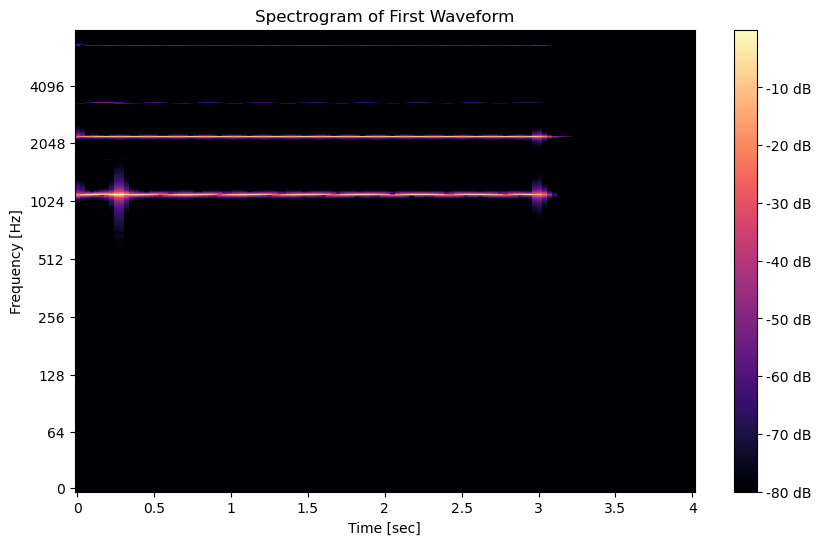

(1025, 126)


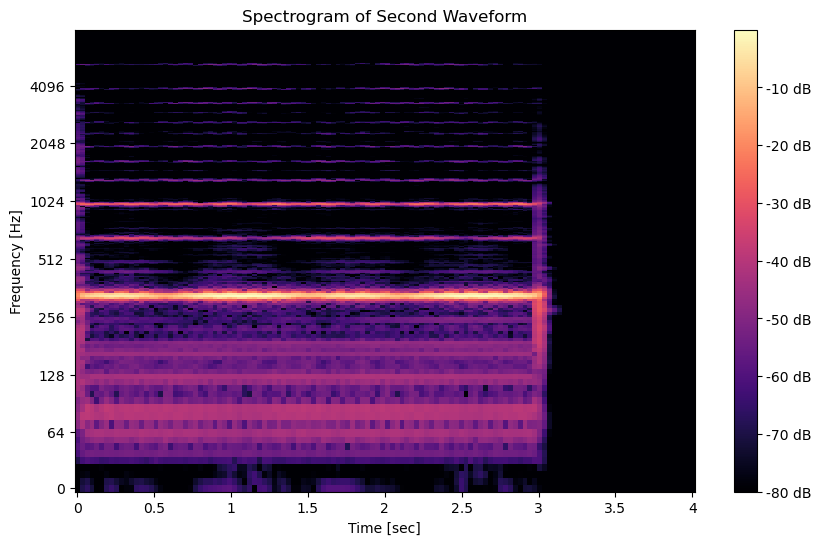

(1025, 126)


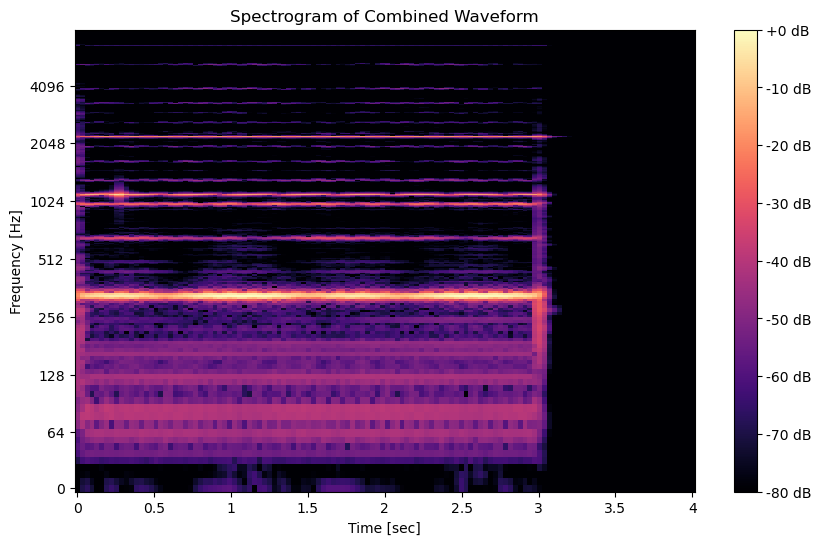

In [31]:
#Generate a random waveform
instrument_list = [organ, flutes]
#Pick a random sample of each instrument
filepaths, labels = pick_samples_and_classify(instrument_list)
print(filepaths)
#Extract .wav data into to a list using librosa
waveforms = add_waveform_to_list(filepaths)

#Combine the waveforms
combined_waveform = combine_waveforms(waveforms)

# Convert the combined waveform to a spectrogram
spectrogram = waveform_to_spectogram(combined_waveform)
#spectogram0 = to_mel_spectrogram(spectrogram, sr = 22050)
# Set all values lower than e-2 to 0
spectrogram_0 = np.where(spectrogram < 1e-2, 0, spectrogram)
# Normalize the spectrogram

#normalized_spectrogram = normalize_spectrogram(spectrogram)
normalized_spectrogram_0 = normalize_spectrogram(spectrogram_0)

# Convert the normalized spectrogram back to audio and save it

#spectogram_to_audio(spectogram0, 22050, "combo1.wav")
spectogram_to_audio(normalized_spectrogram_0, 16000, "combo2.wav")

# Function to plot spectrogram using librosa
def plot_spectrogram(waveform, sr, title):
    # Compute the STFT
    D = librosa.stft(waveform)
    # Convert to magnitude
    D_mag = np.abs(D)
    print(D_mag.shape)
    # Plot the spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(librosa.amplitude_to_db(D_mag, ref=np.max), sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

# Plot the spectrograms for the individual waveforms
sr1 = 16000  # Assuming a sample rate of 16kHz
print(waveforms[0])
plot_spectrogram(waveforms[0], sr1, 'Spectrogram of First Waveform')
plot_spectrogram(waveforms[1], sr1, 'Spectrogram of Second Waveform')
#plot_spectrogram(waveforms[2], sr1, 'Spectrogram of Third Waveform')
# If you want to plot the spectrogram of the combined waveform as well
plot_spectrogram(combined_waveform, sr1, 'Spectrogram of Combined Waveform')

In [26]:
print(combined_waveform)


[3.0517578e-05 2.1362305e-04 2.2888184e-04 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]


(1025, 126)
tensor([[[ 576.5647,  736.1856,  829.5978,  ...,  264.0067,  202.4731,
           116.3418],
         [ 815.7687, 1033.2273, 1244.7266,  ...,  368.7822,  314.2790,
           179.7044],
         [ 753.2336,  996.3845, 1214.2979,  ...,  357.6539,  348.3290,
           211.6551],
         ...,
         [   4.3305,    5.8540,    5.1139,  ...,    2.7268,    2.9861,
             1.8648],
         [   3.9991,    4.5724,    4.6762,  ...,    2.4189,    2.5865,
             1.7705],
         [   2.9576,    3.2877,    3.2158,  ...,    1.9614,    2.1054,
             1.6050]],

        [[ 675.1307,  838.5830,  926.1262,  ...,  298.6791,  219.1075,
           136.0647],
         [ 922.5430, 1206.4111, 1392.3842,  ...,  417.9381,  351.5303,
           206.3394],
         [ 898.0873, 1151.0699, 1349.1791,  ...,  417.7516,  392.9375,
           238.0151],
         ...,
         [   5.2627,    6.3216,    5.8204,  ...,    3.3604,    3.2894,
             2.4277],
         [   4.4141,    6.05

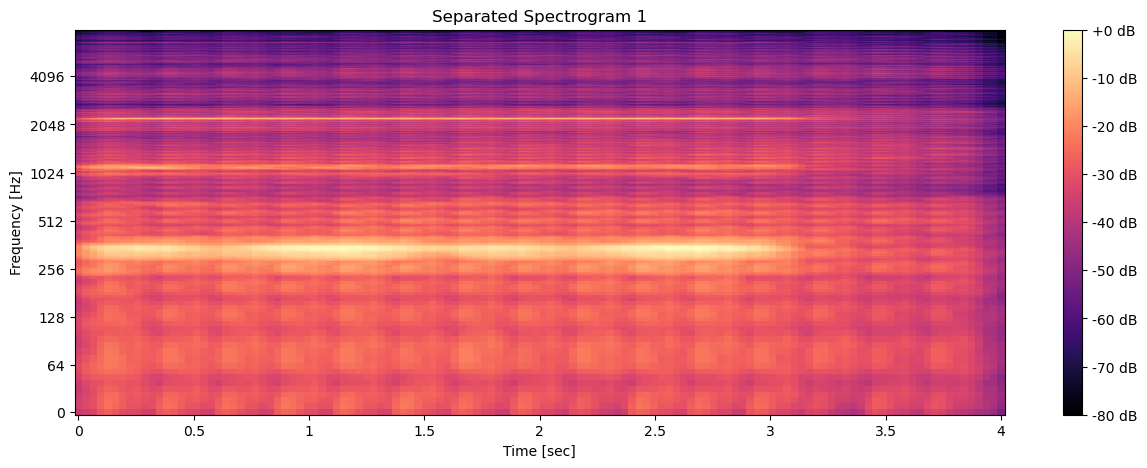

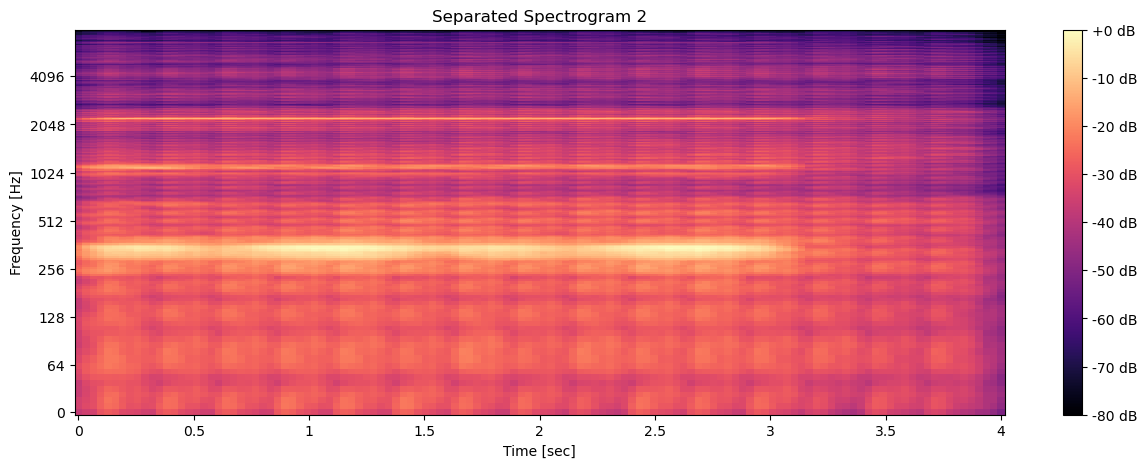

Saved output_audio\sourcebottle_0.wav
Saved output_audio\sourcebottle_1.wav


In [56]:
import torch
import numpy as np
import scipy.signal as signal
import wave
import soundfile as sf
import librosa
# Initialize and load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(input_channels=1,output_channels=2).to(device, dtype=torch.float32)

model.load_state_dict(torch.load('your_model_weights.pth', map_location=device))
model.eval()


with wave.open('combo2.wav', 'rb') as wf:
    input_audio = wf.readframes(-1)
    input_sr = wf.getframerate()

#Load the combined audio waveform
combined_waveform, input_sr = librosa.load('combo2.wav', sr=None)
#print(combined_waveform.shape)
# Compute spectrogram using scipy signal
#f, t, Zxx = signal.spectrogram(combined_waveform, fs=input_sr, nperseg=256)
spectrogram = waveform_to_spectogram(combined_waveform)
#mel_spectrogram = to_mel_spectrogram(spectrogram, input_sr)
print(spectrogram.shape)
# Convert spectrogram to PyTorch tensor
input_tensor = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)  # Add batch and channel dimensions
#print(input_tensor[0])
# Pass input through the model to get predictions
with torch.no_grad():
    output_tensor = model(input_tensor)
    # Normalize the output tensor
    #output_tensor = torch_normalize(output_tensor)
print(output_tensor[0])
# Renormalize the output tensor
def plot_separated_spectrograms(output_tensor, sr):
    for i, spec in enumerate(output_tensor):
        plt.figure(figsize=(15, 5))
        librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.title(f'Separated Spectrogram {i + 1}')
        plt.show()
        
# Convert output tensor to numpy array and save as audio files
output_tensor = output_tensor.squeeze().cpu().numpy()
# Set all values lower than e-2 to 0
#output_tensor = np.where(output_tensor < 1e-2, 0, output_tensor)

# Plot the separated spectrograms
plot_separated_spectrograms(output_tensor, input_sr)
output_folder = "output_audio"
#print(output_tensor)
# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Convert each source back from spectrogram to audio and save
for i, source in enumerate(output_tensor):
    # Convert the spectrogram back to audio

    # Save as .wav file
    output_filepath = os.path.join(output_folder, f'sourcebottle_{i}.wav')
    spectogram_to_audio(source, 16000, output_filepath)
    print(f"Saved {output_filepath}")



In [28]:
#Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(input_channels=1,output_channels=3).to(device, dtype=torch.float32)

model.load_state_dict(torch.load('your_model_weights.pth', map_location=device))
criterion = SDRLoss()

#Apply the model
sdr = 200
while sdr > -10:
    #Pick a random sample from the data
    index = np.random.randint(0, len(train_data))
    input_data = train_data[index]
    y_data1 = val_data[index]
    print(f"max: {np.max(y_data1)}")
    print(f"mean: {np.mean(y_data1)}")
    input_data = np.expand_dims(input_data, axis=0)
    y_data = np.expand_dims(y_data1, axis=0)

    input_data = torch.from_numpy(input_data).to(device, dtype=torch.float32)
    y_data = torch.from_numpy(y_data).to(device, dtype=torch.float32)
    with torch.no_grad():
        output_tensor = model(input_data)
        #evaluate the output
        print(f"pred max: {torch.max(output_tensor)}")
        print(f"pred mean: {torch.mean(output_tensor)}")
        loss, penalty, scores, sdr = criterion(output_tensor, output_tensor)
        
        print(f"SDR: {sdr}, Penalty: {penalty}, scores = {scores}")


for y in y_data1:
    #plot the original spectrograms
    plt.figure()
    plt.imshow(y, cmap='inferno')
    plt.colorbar()
    plt.title("Original")
    
output = torch.squeeze(output_tensor)
for out in output:
    #plot the output spectrograms
    plt.figure()
    plt.imshow(out.cpu().numpy() * 30, cmap='inferno')
    plt.colorbar()
    plt.title("Output")

RuntimeError: Error(s) in loading state_dict for UNet:
	size mismatch for final_conv.weight: copying a param with shape torch.Size([2, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([3, 8, 3, 3]).
	size mismatch for final_conv.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([3]).